# Neural Network Distillation
Ref: http://www.ttic.edu/dl/dark14.pdf

In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

env: KERAS_BACKEND=tensorflow


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import common


from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard

from functools import lru_cache
from sklearn import preprocessing
from sklearn import metrics

In [5]:
@lru_cache(maxsize=None)
def load_keras_model(path):
    return load_model(path)

## Load data

In [6]:
df = common.load_df("../data/insead", "*.csv")

cols = ["loadsys", "drybulb", "rh", "cwrhdr", "cwsfhdr", "cwshdr"]
df = common.Process.replace_nulls(df, cols=cols)
df = common.Process.replace_with_near(df, cols=cols)
df = common.Process.get_normalized_df(df, cols=cols)

In [7]:
sample = df["2016-01":"2016-04"] # sufficiently large one..
sample.shape

(172659, 6)

## Predict target

In [8]:
def get_predicted_values(sample):
    features = ["loadsys", "drybulb", "rh", "cwrhdr", "cwsfhdr"]
    target = ["cwshdr"]
    lookback = 15
    batch_size = 200
    
    x, y = common.prepare_keras_data(sample, features, target, lookback, batch_size)
    model = load_keras_model("../output/cwshdr2.h5")
    predicted = model.predict(x, batch_size=batch_size)
    
    return common.Reshape.inv_y(predicted)

In [9]:
cwshdr_pred = get_predicted_values(sample)

delta = sample.shape[0] - cwshdr_pred.shape[0]
sample = sample[delta:]
sample["cwshdr_pred"] = cwshdr_pred

## Train model with predicted value as target
This time the model is little less complex.. 

In [10]:
# manually select training and validaiton data.
batch_size = 200
lookback = 15
train_df = sample["2016-01-01":"2016-02"]
validation_df = sample["2016-03-01":"2016-03-10"]
features = ["loadsys", "drybulb", "rh", "cwrhdr", "cwsfhdr"]
target = ["cwshdr_pred"]

# Prepare features and target vectors
train_x, train_y = common.prepare_keras_data(train_df, features, target, lookback, batch_size)
validation_x, validation_y = common.prepare_keras_data(validation_df, features, target, lookback, batch_size)
print(train_x.shape, train_y.shape)

(85600, 1, 75) (85600, 1, 1)


In [ ]:
model = Sequential([
    LSTM(150, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, return_sequences=True),
    Dense(1)
])

model.compile(
    loss=mean_squared_error,
    optimizer="adam",
    metrics=["accuracy", mean_absolute_percentage_error]
)

for epoch in range(300):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        epochs=1,
        validation_data=(validation_x, validation_y),
        callbacks=[TensorBoard(log_dir="../output/keras18")])
    model.reset_states()
    if epoch % 50 == 0:
        print("At epoch ", epoch)

In [78]:
model.save("../output/cwshdr4.h5")

In [11]:
model = load_model("../output/cwshdr4.h5")

In [18]:
from keras_diagram import ascii
print(ascii(model))

    InputLayer (200, 1, 75)  
          LSTM (200, 1, 150) 
         Dense (200, 1, 1)   



Ohooo! converging super fastly.. Not sure what its going to mean.

## Metrics
Compare now the the actual values... (not the target used for modeling)

In [79]:
# Test the validation sample...
x, y = common.prepare_keras_data(validation_df, features, ["cwshdr"], lookback, batch_size)

predicted_y = model.predict(x, batch_size=batch_size) # predict
predicted_y = common.Reshape.inv_y(predicted_y)
validation_y = common.Reshape.inv_y(y)

print("MSE: ", metrics.mean_squared_error(validation_y, predicted_y))
print("MAPE: ", common.mean_absolute_percent_error(validation_y, predicted_y))

MSE:  0.00101682704819
MAPE:  4.26507063471


**Hehehehehe.**

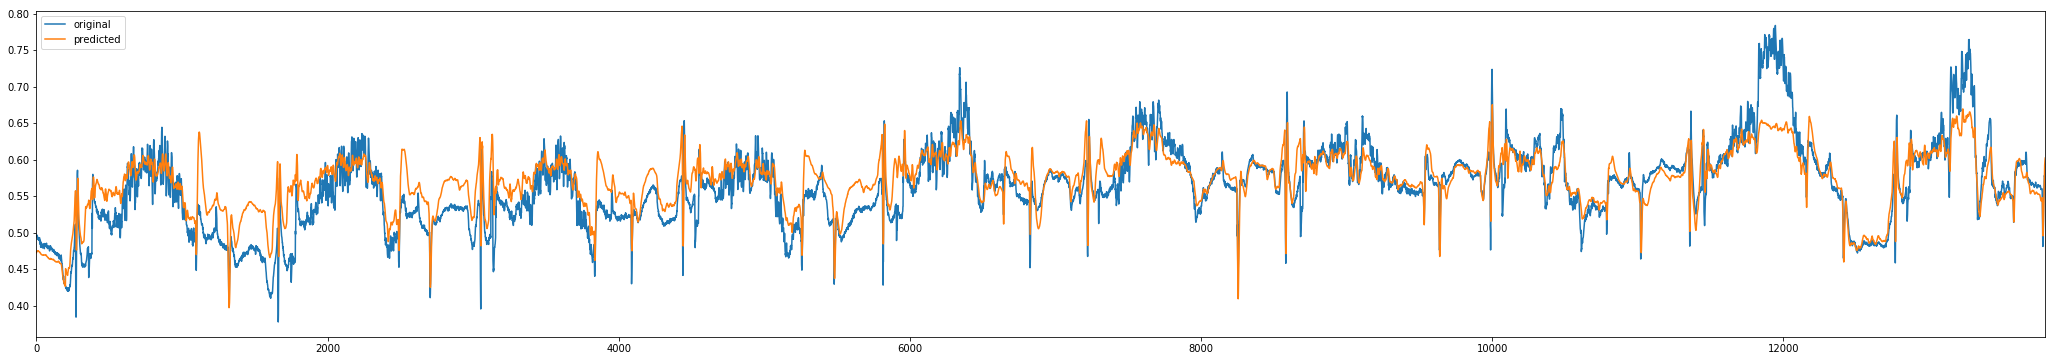

In [80]:
plot_df = pd.DataFrame({"original": validation_y, "predicted": predicted_y})
ax = plot_df.plot(figsize=(36,6))